# CSIRO Image2Biomass – Análisis y Modelado

Este notebook corresponde al proyecto de la competencia:

[CSIRO - Image2Biomass Prediction](https://www.kaggle.com/competitions/csiro-biomass)
hecho por: Julian Villaseñor y Leonardo Brambila
En este notebook haremos:

- Carga de datos desde `import.py`
- Análisis exploratorio (EDA)
- Inspección de variables
- Preparación básica para modelos de regresión


In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# Importar funciones locales
from data_loader import unzip_biomass, load_data


In [4]:
unzip_biomass()
train, test = load_data()
train.head()


Descomprimiendo data\csiro-biomass.zip en data\csiro-biomass...
✓ Descompresión completa.
Train shape: (1785, 9)
Test shape: (5, 3)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [5]:
# Para simplificar, usamos 'df' como alias de train
df = train.copy()

# Resumen estadístico de columnas numéricas
display(df.describe())

# Info de tipos y nulos
df.info()

# Revisar si hay datos faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Valores únicos por columna
print("\nValores únicos por columna:")
print(df.nunique())


,Pre_GSHH_NDVI,Height_Ave_cm,target
count,1785.000000,1785.000000,1785.000000
mean,0.657423,7.595985,24.782295
std,0.151972,10.273725,25.823738
min,0.160000,1.000000,0.000000
25%,0.560000,3.000000,4.818200
50%,0.690000,4.000000,18.200000
75%,0.770000,7.000000,35.940600
max,0.910000,70.000000,185.700000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB

Valores faltantes por columna:
sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

Valores únicos por columna:
sample_id        1785
image_path        357
Sampling_Date      28
State               4
Species            15
P

In [6]:
df['target_name'].value_counts()


target_name
Dry_Clover_g    357
Dry_Dead_g      357
Dry_Green_g     357
Dry_Total_g     357
GDM_g           357
Name: count, dtype: int64

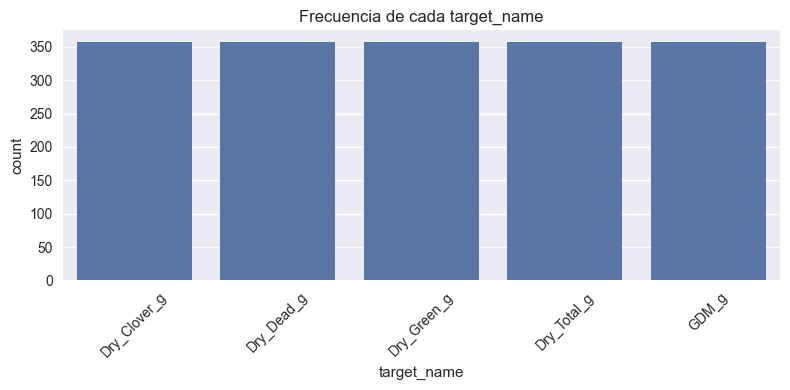

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='target_name', order=df['target_name'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Frecuencia de cada target_name")
plt.tight_layout()
plt.show()


In [10]:
# Remover duplicados por ruta de imagen
df_image = df.drop_duplicates(subset='image_path', keep='first').copy()

print("Filas originales:", df.shape[0])
print("Filas tras eliminar imágenes duplicadas:", df_image.shape[0])


Filas originales: 1785
Filas tras eliminar imágenes duplicadas: 357


In [11]:
# Asegurar que Sampling_Date sea datetime
df_image['Sampling_Date'] = pd.to_datetime(df_image['Sampling_Date'], errors='coerce')

# Crear columnas de año y mes
df_image['Year'] = df_image['Sampling_Date'].dt.year
df_image['Month'] = df_image['Sampling_Date'].dt.month

df_image[['Sampling_Date', 'Year', 'Month']].head()


,Sampling_Date,Year,Month
0,2015-09-04,2015,9
5,2015-04-01,2015,4
10,2015-09-01,2015,9
15,2015-05-18,2015,5
20,2015-09-11,2015,9


In [12]:
df_image.groupby(['Year', 'Month'])['sample_id'].count().head(20)


Year  Month
2015  1        17
      2        24
      4        10
      5        42
      6        53
      7        41
      8        37
      9        67
      10       29
      11       37
Name: sample_id, dtype: int64

Filas con target_name = 'Dry_Total_g': 357


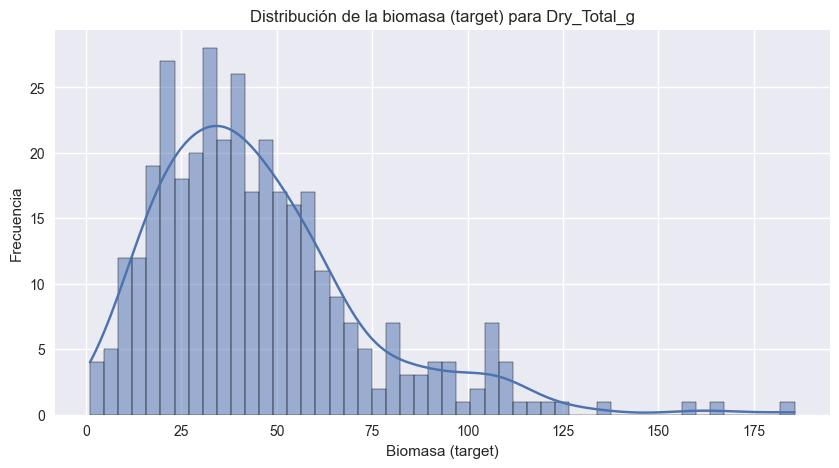

In [13]:
# Filtrar solo registros con target_name = 'Dry_Total_g'
df_total = df[df['target_name'] == 'Dry_Total_g']

print("Filas con target_name = 'Dry_Total_g':", df_total.shape[0])

plt.figure(figsize=(10, 5))
sns.histplot(df_total['target'], bins=50, kde=True)
plt.title('Distribución de la biomasa (target) para Dry_Total_g')
plt.xlabel('Biomasa (target)')
plt.ylabel('Frecuencia')
plt.show()


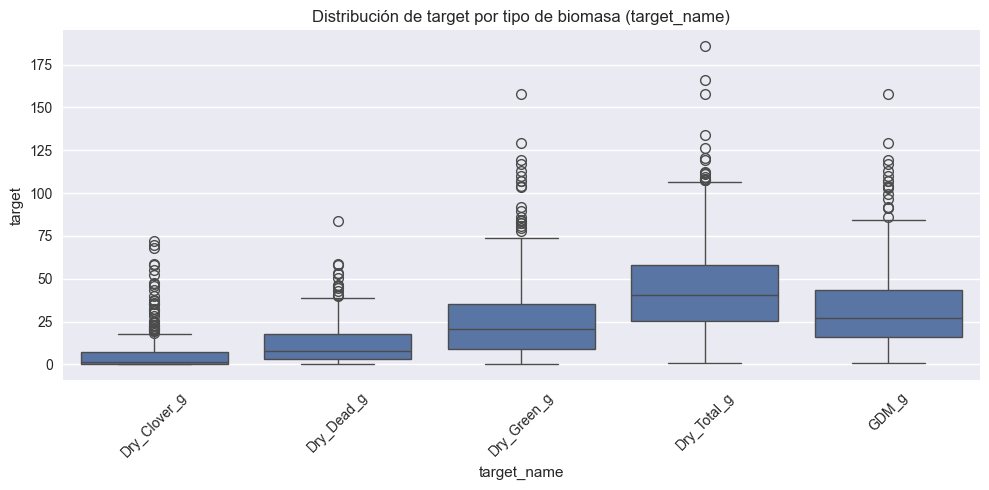

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='target_name', y='target')
plt.xticks(rotation=45)
plt.title('Distribución de target por tipo de biomasa (target_name)')
plt.tight_layout()
plt.show()


In [16]:
df["Sampling_Date"] = pd.to_datetime(df["Sampling_Date"], errors="coerce")

# Crear columnas de año y mes
df["Year"] = df["Sampling_Date"].dt.year
df["Month"] = df["Sampling_Date"].dt.month

df[["Sampling_Date", "Year", "Month"]].head()

,Sampling_Date,Year,Month
0,2015-09-04,2015,9
1,2015-09-04,2015,9
2,2015-09-04,2015,9
3,2015-09-04,2015,9
4,2015-09-04,2015,9


In [17]:
y = df["target"]

# Columnas que NO usaremos como features directas
cols_to_drop = ["target", "sample_id", "image_path", "Sampling_Date"]

X = df.drop(columns=cols_to_drop, errors="ignore")

print("Columnas en X:")
print(X.columns.tolist())

Columnas en X:
['State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'Year', 'Month']


In [18]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas :", num_cols)
print("Categóricas:", cat_cols)

Numéricas : ['Pre_GSHH_NDVI', 'Height_Ave_cm', 'Year', 'Month']
Categóricas: ['State', 'Species', 'target_name']


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [20]:
# Pipeline para numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline para categóricas
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combinamos en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# Modelo baseline: RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Pipeline completo: preprocesamiento + modelo
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", rf_model)
])


In [21]:
scores = cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rmse_scores = -scores  # porque vienen en negativo
print("RMSE por fold:", rmse_scores)
print("RMSE promedio:", rmse_scores.mean())
print("Desviación estándar:", rmse_scores.std())

RMSE por fold: [11.24928851 10.14766783 10.71195749 12.96365765  9.22404341]
RMSE promedio: 10.859322978221744
Desviación estándar: 1.2476062222891926


In [22]:
import xgboost
from xgboost import XGBRegressor

In [23]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# ---- Modelo 2: XGBoost ----
model2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

In [24]:
scores2 = cross_val_score(
    model2,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rmse_scores2 = -scores2
print("RMSE por fold (XGBoost):", rmse_scores2)
print("RMSE promedio (XGBoost):", rmse_scores2.mean())
print("Desviación estándar:", rmse_scores2.std())


RMSE por fold (XGBoost): [11.42932661 10.08847308 10.38087296 12.32664916  9.21600558]
RMSE promedio (XGBoost): 10.68826547899523
Desviación estándar: 1.0821518345531678


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
xgb_param_dist = {
    "xgb__n_estimators": randint(300, 1200),
    "xgb__learning_rate": uniform(0.01, 0.2),
    "xgb__max_depth": randint(3, 10),
    "xgb__subsample": uniform(0.6, 0.4),
    "xgb__colsample_bytree": uniform(0.6, 0.4),
    "xgb__min_child_weight": randint(1, 10),
    "xgb__gamma": uniform(0, 2)
}

In [26]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=25,                 # puedes subir a 50 si tienes tiempo
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [27]:
search.fit(X, y)

print("Mejores parámetros encontrados:")
print(search.best_params_)

best_rmse = -search.best_score_
print(f"Mejor RMSE encontrado: {best_rmse:.4f}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores parámetros encontrados:
{'xgb__colsample_bytree': np.float64(0.908897907718663), 'xgb__gamma': np.float64(0.3974313630683448), 'xgb__learning_rate': np.float64(0.01110442342472048), 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 892, 'xgb__subsample': np.float64(0.88453678109946)}
Mejor RMSE encontrado: 10.6228


In [28]:
model2_final = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=892,
        learning_rate=0.01110442342472048,
        max_depth=5,
        subsample=0.88453678109946,
        colsample_bytree=0.908897907718663,
        min_child_weight=3,
        gamma=0.3974313630683448,
        random_state=42,
        n_jobs=-1
    ))
])


In [29]:
model2_final.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pre_GSHH_NDVI',
                                                   'Height_Ave_cm', 'Year',
                                                   'Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State', 'S...
                              gamma=0.3974313630683448, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.01110442342472048, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=892, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [33]:
df_train = train.copy()
df_test = test.copy()

print("Columnas de train:", df_train.columns.tolist())
print("Columnas de test :", df_test.columns.tolist())

# Columnas que NO queremos como features
cols_to_exclude = ["target", "sample_id", "image_path"]

# Columnas comunes entre train y test que sí se pueden usar como features
common_cols = [c for c in df_train.columns 
               if c in df_test.columns and c not in cols_to_exclude]

print("Columnas comunes usadas como features:", common_cols)

# Construir X, X_test y y
X = df_train[common_cols].copy()
X_test = df_test[common_cols].copy()
y = df_train["target"]


Columnas de train: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']
Columnas de test : ['sample_id', 'image_path', 'target_name']
Columnas comunes usadas como features: ['target_name']


In [34]:

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas :", num_cols)
print("Categóricas:", cat_cols)

Numéricas : []
Categóricas: ['target_name']


In [35]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_cols)
    ]
)

model2_final = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=892,
        learning_rate=0.01110442342472048,
        max_depth=5,
        subsample=0.88453678109946,
        colsample_bytree=0.908897907718663,
        min_child_weight=3,
        gamma=0.3974313630683448,
        random_state=42,
        n_jobs=-1
    ))
])

In [36]:
model2_final.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['target_name'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.90889790771...
                              gamma=0.3974313630683448, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.01110442342472048, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=892, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [37]:

scores_model2 = cross_val_score(
    model2_final,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rmse_scores2 = -scores_model2
print("RMSE por fold (XGB usando solo target_name):", rmse_scores2)
print("RMSE promedio:", rmse_scores2.mean())
print("Desviación estándar:", rmse_scores2.std())

RMSE por fold (XGB usando solo target_name): [22.1616487  23.01962862 20.64398041 21.04760525 21.49170176]
RMSE promedio: 21.672912948142802
Desviación estándar: 0.8408394736009199


In [38]:
y_pred = model2_final.predict(X_test)

submission = pd.DataFrame({
    "sample_id": test["sample_id"],
    "target": y_pred
})

submission.head()


,sample_id,target
0,ID1001187975__Dry_Clover_g,6.647441
1,ID1001187975__Dry_Dead_g,12.059647
2,ID1001187975__Dry_Green_g,26.672184
3,ID1001187975__Dry_Total_g,45.283833
4,ID1001187975__GDM_g,33.304680
